# TESTBED FOR FULL STATE FEEDBACK

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook describes the proportional, integral, and differential controllers.

# Preliminaries

## Imports

In [1]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

## Constants

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)
SYSTEM = "system"
CONTROLLER = "controller"
CONTROLLER_IN = "controller.in"
CONTROLLER_REF = "controller.ref"
CONTROLLER_OUT = "controller.out"
SIGNAL_SUM = "signal_sum"
SIGNAL_SUM_IN1 = "signal_sum.in1"
SIGNAL_SUM_IN2 = "signal_sum.in2"
SIGNAL_SUM_OUT = "signal_sum.out"

# Antimony Model

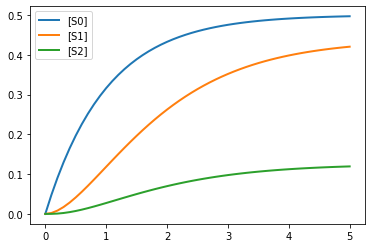

In [39]:
ANT_MODEL = """
-> S0; k0
S0 -> S1; k1*S0
S1 -> S2; k2*S1
S2 -> S1; k3*S2
S2 -> ; k4*S2

S0 = 0
S1 = 0
S2 = 0
S3 = 0
k0 = 0.5
k1 = 1
k2 = 2
k3 = 3
k4 = 4
"""
rr = te.loada(ANT_MODEL)
rr["k0"] = 0.5
rr.simulate()
rr.plot()

# Model of Glycoytic Oscillations (BioModels 206)

In [28]:
BIOMD206 = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml"

**Reactions in Glycolytic Oscillations**

``at`` is ``ATP``; ``s5`` is ``pyruvate``.

    v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
    v2: s2 -> 2 s3; compartment_*k2*s2;
    v3: s3 + na -> s4 + at_;compartment_*((k31*k32*s3*na*(atot - at_) 
        - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
    v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
    v5: s5 -> s6; compartment_*k5*s5;
    v7: at_ -> ; compartment_*k7*at_;
    v8: s3 -> na; compartment_*k8*s3*(ntot - na);
    v9: s6o -> ; compartment_*k9*s6o;
    v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
    v6: s6 -> na; compartment_*k6*s6*(ntot - na);
    v0:  -> s1; compartment_*k0;

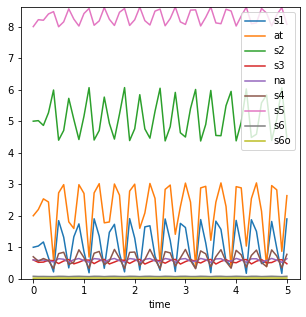

In [29]:
ctlsb = ctl.ControlSBML(BIOMD206)
ctlsb.plotTrueModel(figsize=(5,5))

# Testbed for PID Control

In [30]:
# Elements of the system
factory = ctl.IOSystemFactory()
kp = 0.01
ki = 0
kd = 0
input_name = "at"
output_name = "s5"
# Create the elements of the feedback loop
ctlsb = ctl.ControlSBML(BIOMD206, input_names=[input_name], output_names=[output_name])
system = ctlsb.makeNonlinearIOSystem("system")
controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
sum_R_S = factory.makeAdder("sum_R_S")

In [31]:
# Create the closed loop system
system_in = "system.%s" % input_name
system_out = "system.%s" % output_name
closed_loop = control.interconnect(
  [sum_R_S, system, controller ], 
  connections=[
    ['controller.in', 'sum_R_S.out'],    # e(t)
    [system_in,   'controller.out'],   # u(t)
    ['sum_R_S.in1', "-" + system_out],
  ],
  inplist=["sum_R_S.in2"],
  outlist=["sum_R_S.in2", system_in, system_out],
)

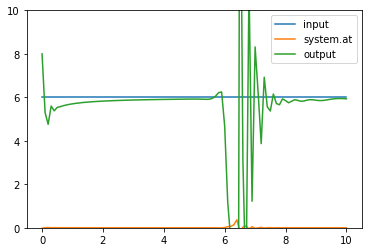

In [32]:
X0 = ctl.makeStateVector(closed_loop)
times = ctl.makeSimulationTimes(0, 10, 10)
# Need the initial state
result = control.input_output_response(closed_loop, T=times, U=6, X0=X0)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
plt.plot(result.t, result.outputs[2].flatten())
#plt.plot(result.t, result.outputs[3].flatten())
plt.ylim([0, 10])
legends = ["input", system_in, "output"]
plt.legend(legends)

## Evaluation Environment for PID Control

We want to repeatedly evaluate different controller parameters.
This is cumbersome to do if we have to rerun multiple cells and reset various parameters.
It's much more efficient to create an evaluation function.

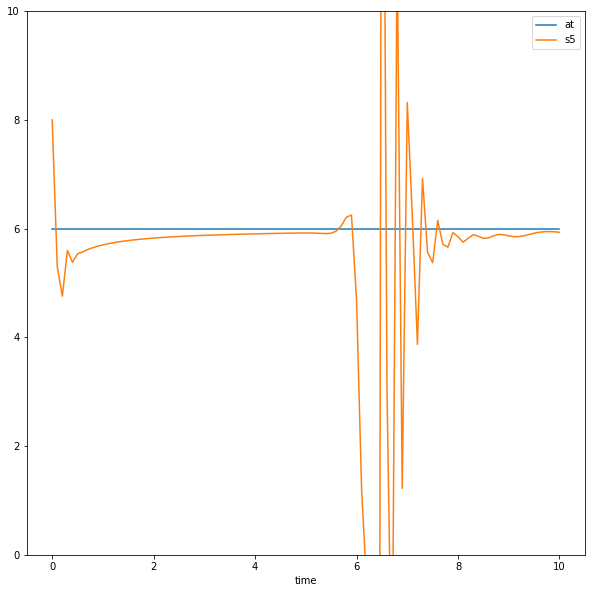

In [9]:
def evaluatePIDController(model=MODEL, input_name="at", output_name="s5", ref_val=1,
                     kp=0.01, ki=0, kd=0, **kwargs):
    """
    Creates an evaluation testbed and plots the step response.
    
    Parameters
    ----------
    model: str
        System under control
    input_name: str
        Input species for the system
    output_name: str
        Output species from the system
    ref_val: float
        Regulate output species to this value
    kp: float
    ki: float
    kd: float
    kwargs: dict
        plotting options
    
    Returns
    -------
    DataFrame
       Columns: input_name, output_name
       Index: time in ms
    """
    # Elements of the system
    factory = ctl.IOSystemFactory()
    ctlsb = ctl.ControlSBML(MODEL, input_names=[input_name], output_names=[output_name])
    system = ctlsb.makeNonlinearIOSystem(SYSTEM)
    controller = factory.makePIDController(CONTROLLER, kp=kp, ki=ki, kd=kd)
    signal_sum = factory.makeAdder(SIGNAL_SUM)
    # Connections between elements
    system_in = "system.%s" % input_name
    system_out = "system.%s" % output_name
    closed_loop = control.interconnect(
      [signal_sum, system, controller ], 
      connections=[
        [CONTROLLER_IN, SIGNAL_SUM_OUT],      # e(t)
        [system_in, CONTROLLER_OUT],          # u(t)
        [SIGNAL_SUM_IN1, "-" + system_out],   # y(t)
      ],
      inplist=[SIGNAL_SUM_IN2],
      outlist=[SIGNAL_SUM_IN2, system_out],
    )
    # Simulate and plot
    X0 = ctl.makeStateVector(closed_loop)
    times = ctl.makeSimulationTimes(0, 10, 10)
    # Need the initial state
    result = control.input_output_response(closed_loop, T=times, U=ref_val, X0=X0)
    df = pd.DataFrame({
        "time": result.t.flatten(),
        input_name: result.y[0].flatten(),
        output_name: result.y[1].flatten(),
    })
    ts = ctl.Timeseries(df)
    ctl.plotOneTS(ts, **kwargs)
    return ts
    
# Tests
ts = evaluatePIDController(ref_val=6, ylim=[0, 10])

# Testbed for Full State Controller

## Factory for Full State Controller

In [66]:
def makeFullStateController(name, state_names, kp_vec, dcgain=1, ref_val=1):
    """
    Creates a full state feedback controller.
    
    Parameters
    ----------
    name: str
        Name of the system
    kp_vec: list-float
        kp_vec[0] - reference
        kp_vec[1:] - gain constants
    dcgain: float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    kp_vec = np.array(kp_vec)
    def outfcn(time, __, u_vec, ___):
        # u_vec: list-float - vector of internal state deviations
        ref = u_vec[0]
        arr = np.array(u_vec[1:])
        prod = kp_vec.dot(arr)
        output = ref_val/dcgain - prod
        return output
    # Manfacture the input names corresonding to the system states
    input_names = list(state_names)
    input_names.insert(0, "ref")
    return control.NonlinearIOSystem(
        None, outfcn, inputs=input_names, outputs=["out"],
        name=name)

# Tests
kp_vec = [1, 2]
state_names = ["a", "b"]
controller = makeFullStateController("controller", state_names, kp_vec)
times = [0, 1, 2, 3, 4]
refs = np.repeat(1, len(times))
U = np.array(list(zip(refs, times, times)))
U = U.transpose()
result = control.input_output_response(controller, T=times, U=U)
assert(len(result.y[0]) == len(times))
#assert(result.y[0][1] == -2)
print("OK!")

OK!


## Calculating ${\bf k_P}$

In [11]:
ctlsb = ctl.ControlSBML(MODEL, input_names=[input_name], output_names=[output_name])
system = ctlsb.makeStateSpace()
system.A

array([[  -64.70588235,     0.        ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [   64.70588235,    -9.8       ,     0.        ,     0.        ,
            0.        ,     0.        ,     0.        ,     0.        ],
       [    0.        ,    19.6       ,  -203.0214267 ,  -160.06424133,
            6.23084401,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,  -134.4614267 ,  -422.90424133,
            6.23084401,     0.        ,   800.        ,     0.        ],
       [    0.        ,     0.        ,   168.7414267 ,   211.48424133,
         -166.23084401,     0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,     0.        ,
          160.        ,    -9.7       ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        ,   160.        ,
            0.        ,     9.7       , -1175.        ,   

In [12]:
system.B

array([[ 89.44530399],
       [-89.44530399],
       [ 10.72920583],
       [ 10.72920583],
       [ 45.27079417],
       [-56.        ],
       [  0.        ],
       [  0.        ]])

In [13]:
poles = [-2-0.1*n for n in range(system.A.shape[0])]
print(poles)
kp = control.place(system.A, system.B, poles)
print(kp)

[-2.0, -2.1, -2.2, -2.3, -2.4, -2.5, -2.6, -2.7]
[[  -2.4793375     4.05156562  -53.00300181  -70.90021277   16.92701614
    -1.68210515  248.58260439 -257.80977566]]


## Evaluation Environment

In [76]:
def evaluateFullStateController(pole=-2, model=BIOMD206, input_name="at", output_name="s5", ref_val=1, end_time=5,
                     time=1, is_plot=True, **kwargs):
    """
    Creates an evaluation testbed and plots the step response.
    
    Parameters
    ----------
    kp_vec: vector of gain constants
    pole: float
        position of dominant pole
    model: str
        System under control
    input_name: str
        Input species for the system
    output_name: str
        Output species from the system
    ref_val: float
        Regulate output species to this value
    kwargs: dict
        plotting options
    
    Returns
    -------
    DataFrame
       Columns: input_name, output_name
       Index: time in ms
    """
    # Elements of the system
    factory = ctl.IOSystemFactory()
    # Construct the NonlinearIOSystem with all states as outputs
    ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=[output_name])
    state_space = ctlsb.makeStateSpace(time=time)
    system_tf = ctlsb.makeTransferFunction(time=time)
    output_names = list(ctlsb.state_names)
    output_names.remove(input_name)
    new_ctlsb = ctl.ControlSBML(model, input_names=[input_name], output_names=output_names)
    system = new_ctlsb.makeNonlinearIOSystem(SYSTEM)
    # Controller
    #state_space = ctlsb.makeStateSpace()
    num_state = new_ctlsb.num_state
    poles = np.array([pole - 0.1*n for n in range(num_state-1)])
    kp_vec = control.place(state_space.A, state_space.B, poles)
    # Find the DC gain of the closed loop system
    Ap = state_space.A - np.matmul(state_space.B, kp_vec)
    new_state_space = ctlsb.makeStateSpace(A_mat=Ap, time=time)
    dcgain = control.ss2tf(new_state_space).dcgain()
    controller = makeFullStateController(CONTROLLER, output_names, kp_vec, ref_val=ref_val, dcgain=dcgain)
    # Connections between elements
    system_out = "%s.%s" % (SYSTEM, output_name)
    system_in = "%s.%s" % (SYSTEM, input_name)
    connections = [["%s.%s" % (CONTROLLER, s), "%s.%s" % (SYSTEM, s)] for s in output_names]
    connections.append([system_in, CONTROLLER_OUT])
    # Created the closed loop system
    closed_loop = control.interconnect(
      [system, controller ], 
      connections=connections,
      inplist=[CONTROLLER_REF],
      outlist=[CONTROLLER_REF, system_out],
    )
    # Simulate and plot
    X0 = ctl.makeStateVector(closed_loop)
    times = ctl.makeSimulationTimes(0, end_time=end_time, points_per_time=5)
    # Need the initial state
    result = control.input_output_response(closed_loop, T=times, U=ref_val, X0=X0)
    df = pd.DataFrame({
        "time": result.t.flatten(),
        input_name: result.y[0].flatten(),
        output_name: result.y[1].flatten(),
    })
    ts = ctl.Timeseries(df)
    if is_plot:
        ctl.plotOneTS(ts, **kwargs)
    return ts
    
# Tests
ts = evaluateFullStateController(model=ANT_MODEL, input_name="S0", output_name="S2", pole=-5, ref_val=5,
                                figsize=(5,5), is_plot=False)
assert(len(ts) > 0)
print("OK!")

OK!


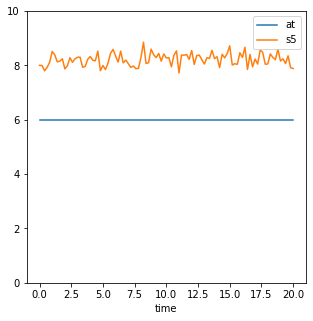

In [79]:
ts = evaluateFullStateController(model=BIOMD206, input_name="at", output_name="s5", pole=-1, ref_val=6,
                                end_time=20, figsize=(5,5), ylim=[0, 10], time=1)